In [1]:
# import libraries
#try:
  # %tensorflow_version only exists in Colab.
  #!pip install tf-nightly
#except Exception:
  #pass

try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import tensorflow as tf
import pandas as pd
from tensorflow import keras
#!pip install tensorflow-datasets
#import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.9.2


In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2023-01-25 11:01:18--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.04s   

2023-01-25 11:01:19 (7.84 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2023-01-25 11:01:19--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==============

In [3]:
# tsv to dataframes

raw_data_train = pd.read_csv('train-data.tsv', sep='\t', header=None)
raw_data_train = raw_data_train.rename(columns={raw_data_train.columns[0]: 'Label', raw_data_train.columns[1]: 'SMS'})
raw_data_train['Label'] = raw_data_train['Label'].map({'ham': 0, 'spam': 1})
label_train =  np.array(raw_data_train['Label'].tolist())

raw_data_valid = pd.read_csv('valid-data.tsv', sep='\t', header=None)
raw_data_valid = raw_data_valid.rename(columns={raw_data_valid.columns[0]: 'Label', raw_data_valid.columns[1]: 'SMS'})
raw_data_valid['Label'] = raw_data_valid['Label'].map({'ham': 0, 'spam': 1})
label_valid =  np.array(raw_data_valid['Label'].tolist())

#print(raw_data_valid)
#print(raw_data_train)
#print(label_train)
#print(label_valid)

In [4]:
# using Tokenizer from TensorFlow 
# hyperparameters
popular_vocabulary_size = 500
oov_token_param = "<OOV>"
max_len = 189

tokenizer = Tokenizer(num_words=popular_vocabulary_size ,oov_token=oov_token_param)
tokenizer.fit_on_texts(raw_data_train['SMS'])
word_index = tokenizer.word_index
# words count
#print('Number of different words: ', len(word_index))

# string to integer with padding (each element must have same length ; adding 0 before to fill in the gaps)
sequences_train = tokenizer.texts_to_sequences(raw_data_train['SMS'])
padded_train = pad_sequences(sequences_train, maxlen= max_len, padding='pre')

sequences_valid = tokenizer.texts_to_sequences(raw_data_valid['SMS'])
padded_valid = pad_sequences(sequences_valid, maxlen= max_len, padding='pre')

In [5]:
# model

model = keras.Sequential()
model.add(tf.keras.layers.Embedding(popular_vocabulary_size, 8, input_length=max_len))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(padded_train, label_train, epochs=20, validation_data=(padded_valid, label_valid),callbacks =[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)])

Epoch 1/20
131/131 [==============================] - 5s 6ms/step - loss: 0.3718 - accuracy: 0.8610 - val_loss: 0.2526 - val_accuracy: 0.8685
Epoch 2/20
131/131 [==============================] - 0s 4ms/step - loss: 0.1711 - accuracy: 0.9366 - val_loss: 0.1285 - val_accuracy: 0.9670
Epoch 3/20
131/131 [==============================] - 0s 4ms/step - loss: 0.1018 - accuracy: 0.9694 - val_loss: 0.0940 - val_accuracy: 0.9734
Epoch 4/20
131/131 [==============================] - 0s 4ms/step - loss: 0.0756 - accuracy: 0.9768 - val_loss: 0.0766 - val_accuracy: 0.9749
Epoch 5/20
131/131 [==============================] - 0s 3ms/step - loss: 0.0609 - accuracy: 0.9818 - val_loss: 0.0670 - val_accuracy: 0.9770
Epoch 6/20
131/131 [==============================] - 0s 3ms/step - loss: 0.0515 - accuracy: 0.9847 - val_loss: 0.0603 - val_accuracy: 0.9770
Epoch 7/20
131/131 [==============================] - 0s 3ms/step - loss: 0.0455 - accuracy: 0.9871 - val_loss: 0.0568 - val_accuracy: 0.9792
Epoch 

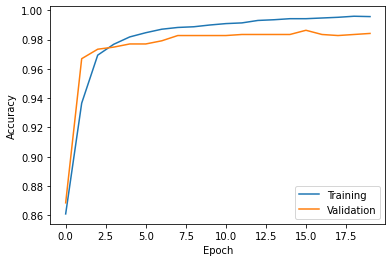

In [6]:
# accuracy plot

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.show()

In [7]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
    temp_sequence = tokenizer.texts_to_sequences([pred_text])
    temp_sequence = pad_sequences(temp_sequence, maxlen=max_len)
    prediction = model.predict(temp_sequence)[0].tolist()
    prediction_txt = 'ham' if prediction[0] < 0.2 else 'spam'
    prediction.append(prediction_txt)
    return (prediction)

pred_text = "sale today! to stop texts call 98912460324"

prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 0s 80ms/step
[0.5689487457275391, 'spam']


In [8]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 [==============================] - 0s 16ms/step
You passed the challenge. Great job!
